# Category Recomendation Random Forest Transfer
---

In [9]:
# imports
import json
import time
import random
import joblib
import matplotlib.pyplot as plt
from itertools import permutations
from seaborn import heatmap

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold


In [10]:
data_path : str = "./dataset/"
models_path : str = "../web/models/transfer"
cities =  ["Burgos", "León", "Palencia", "Salamanca", "Valladolid"]

In [11]:
def mean_reciprocal_rank(real_categories, category_probs, categories) -> float:
    mrr: float = 0
    sample_size = len(category_probs)

    for real, probs in zip(real_categories, category_probs):
        ranking: list = [[category, prob]
                         for category, prob in zip(categories, probs)]
        ranking.sort(key=lambda x: x[1], reverse=True)

        for index, prob in enumerate(ranking, start=1):
            if prob[0] == real:
                mrr += 1/index
                break

    return mrr/sample_size


In [12]:
def construct_dataset(data_path: str, city: str) -> dict:


    # Abrimos el fichero de datos y lo convertimos a un dataframe
    with open(f"{data_path}Q_{city}.json", "r") as file:
        data = json.load(file)
    df = pd.json_normalize(data)

    # Separamos en dataframes de atributos y etiquetas
    X= df.drop('Categoria', axis=1)
    Y = df['Categoria']



    return X, Y

In [13]:
def get_intersection(i,j):
    return np.intersect1d(i.unique(),j.unique())

In [14]:
def cross_validate_random_forest(dataframe, k=5, **kwargs):

    # Creamos el objeto para KFold para hacer validación cruzada
    kf = KFold(n_splits=k, shuffle=True, random_state=random.randint(0, 100))

    # Dataframes de atributos y etiquetas
    X= dataframe.drop('Categoria', axis=1)
    Y = dataframe['Categoria']


    folds_mrr = []

    for n_fold, (train, test) in enumerate(kf.split(X), start=1):
        print(f">>> Fold: {n_fold}")
        classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        fold_time = time.time()


        # Definimos conjunto de test
        df_train_x = X.iloc[train]
        df_train_y = Y.iloc[train]

        # Definimos conjunto de test
        df_test_x = X.iloc[test]
        df_test_y = Y.iloc[test]

        # Entrenamos el modelo
        classifier.fit(df_train_x, df_train_y)

        # Predicciones
        preds = classifier.predict_proba(df_test_x)

        # Calculamos el MRR
        mrr = mean_reciprocal_rank(df_test_y, preds, classifier.classes_)
        folds_mrr.append(mrr)
        print(f"> MRR: {mrr}")
        print(f"> Tiempo fold {n_fold}: {time.time() - fold_time :.1f} s")

    return folds_mrr


In [15]:
def get_dataset(source: str, target: str):
    with open(f"{data_path}Q_{source}.json", "r") as file_source, open(f"{data_path}Q_{target}.json", "r") as file_target:

        data_source: list = json.load(file_source)
        data_target: list = json.load(file_target)

        categories_target: set = {place["Categoria"] for place in data_target}
        categories_source: set = (
            {place["Categoria"] for place in data_source})

        categories = categories_target.intersection(categories_source)

        source_final_data = []
        for data in data_source:

            if data["Categoria"] not in categories:
                continue

            data["QualityIndices"] = {k: v for k, v in data["QualityIndices"].items(
            ) if k in categories}
            source_final_data.append(data)

        target_final_data = []

        for data in data_target:

            if data["Categoria"] not in categories:
                continue

            data["QualityIndices"] = {k: v for k, v in data["QualityIndices"].items(
            ) if k in categories}
            target_final_data.append(data)

        df_source = pd.json_normalize(source_final_data)
        df_target = pd.json_normalize(target_final_data)
        df_target = df_target[df_source.columns.to_list()]

        return df_source, df_target , categories

In [16]:
models_dict : dict = {city: dict() for city in cities}
models_dict_MRR : dict = {city: dict() for city in cities}

for origen, destino in permutations(cities,2):
    print(f"{origen}-->{destino}")
    df_source, df_target, categories = get_dataset(origen, destino)

    df_source_Y = df_source["Categoria"]
    df_target_Y = df_target["Categoria"]

    df_source_X = df_source.drop('Categoria', axis=1)
    df_target_X = df_target.drop('Categoria', axis=1)

    model : RandomForestClassifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    model.fit(df_source_X, df_source_Y)

    preds = model.predict_proba(df_target_X)

    mrr = mean_reciprocal_rank(df_target_Y, preds, model.classes_)
    print(f"MRR: {mrr}")
    models_dict[origen][destino] = model
    models_dict_MRR[origen][destino] = mrr



Burgos-->León
MRR: 0.25268727137926844
Burgos-->Palencia
MRR: 0.23483364650939895
Burgos-->Salamanca
MRR: 0.17091241226219933
Burgos-->Valladolid
MRR: 0.19793961696417858
León-->Burgos
MRR: 0.2098768755542577
León-->Palencia
MRR: 0.2830995476337159
León-->Salamanca
MRR: 0.1841387115928202
León-->Valladolid
MRR: 0.23034578967635608
Palencia-->Burgos
MRR: 0.20642647026491795
Palencia-->León
MRR: 0.2969624063879355
Palencia-->Salamanca
MRR: 0.19718141816520077
Palencia-->Valladolid
MRR: 0.20489990661701107
Salamanca-->Burgos
MRR: 0.18992339442541709
Salamanca-->León
MRR: 0.24812383182382458
Salamanca-->Palencia
MRR: 0.23835251428535542
Salamanca-->Valladolid
MRR: 0.20453754943707989
Valladolid-->Burgos
MRR: 0.18302321024854568
Valladolid-->León
MRR: 0.260611538999085
Valladolid-->Palencia
MRR: 0.20212830334816154
Valladolid-->Salamanca
MRR: 0.18310047407880253


In [17]:

for ki, kv, in models_dict.items():

    for k,v in kv.items():

        joblib.dump(v,f"{models_path}/{ki}-{k}.gz", compress=9)

Text(0.5, 296.61111111111103, 'Source')

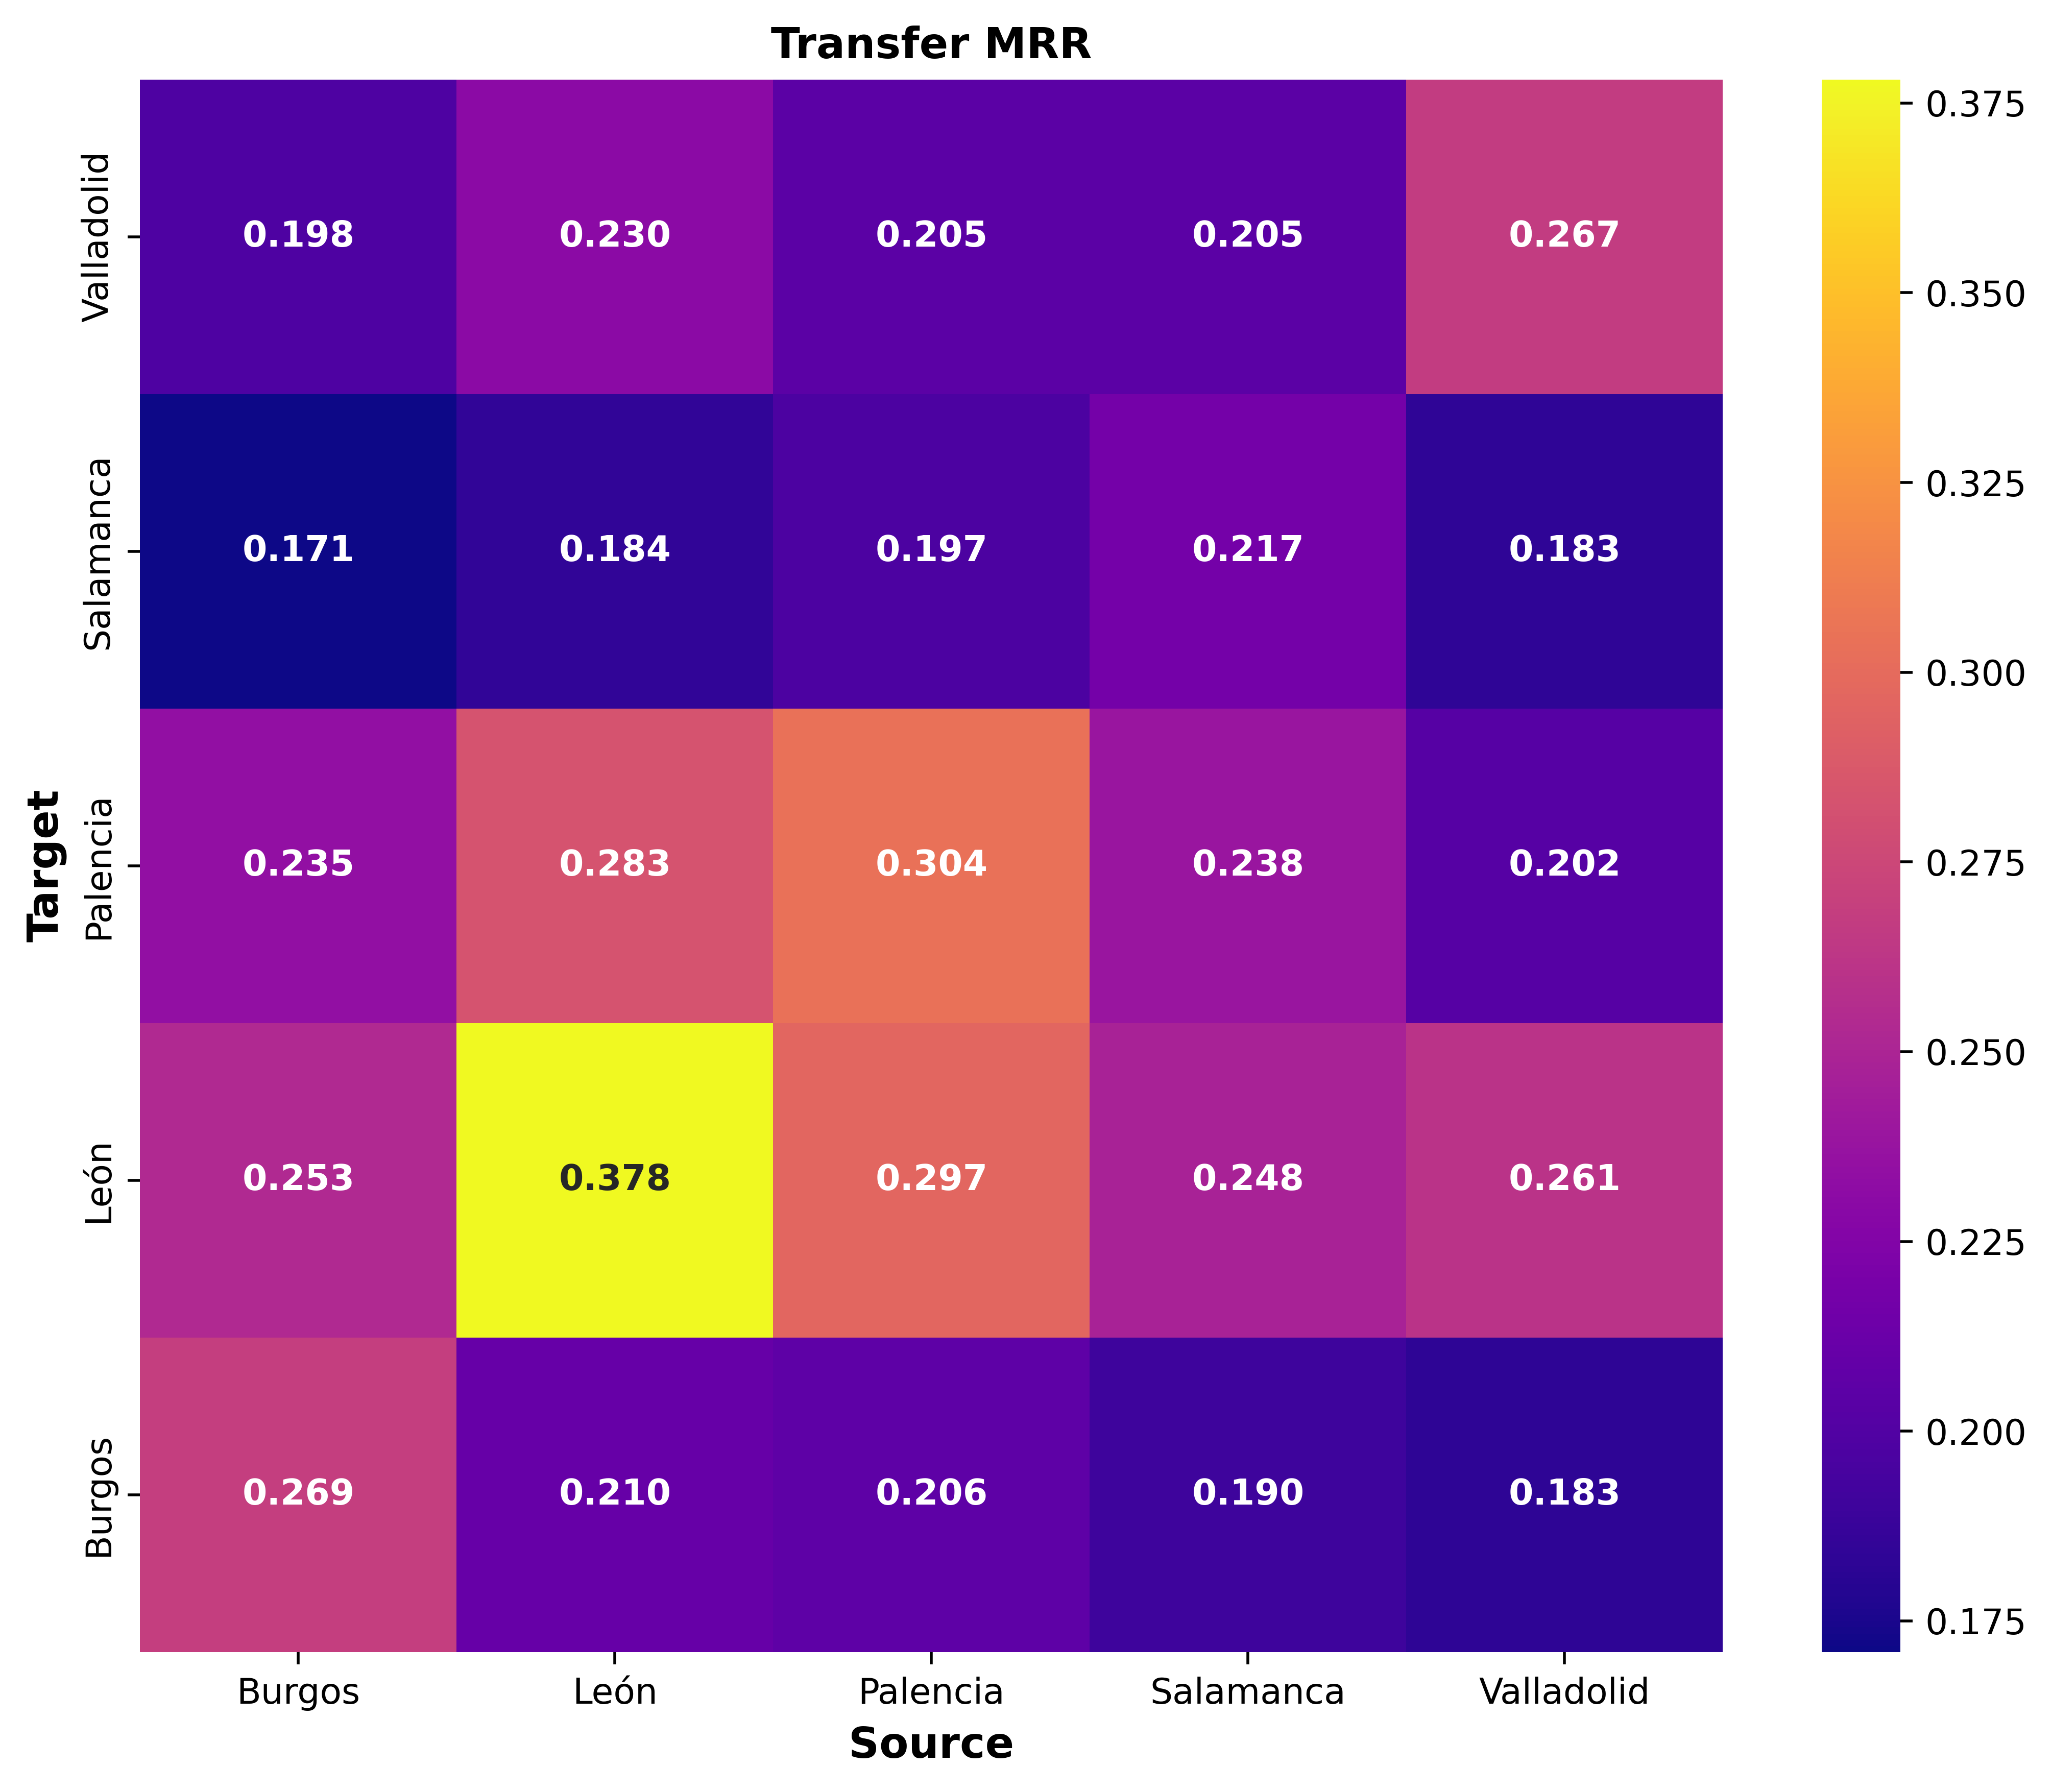

In [18]:
with open("./CompleteMRR.json", "r", encoding="utf-8") as RF_MRR:
    mrr_json = json.load(RF_MRR)
    
    for k,v in mrr_json.items():
        models_dict_MRR[k][k] = v["Qrandom_forest"]

df = pd.DataFrame.from_dict(models_dict_MRR)

df = df.reindex(reversed(cities), axis=0)
df = df[cities]
plt.figure(figsize=(10,8), dpi=500)
plt.title("Transfer MRR", fontweight='bold')
heatmap(df, cmap="plasma", annot=True, fmt='.3f' , annot_kws={"weight": "bold"})
plt.ylabel("Target", fontsize=12, fontweight='bold')
plt.xlabel("Source", fontsize=12, fontweight='bold')



In [19]:
for k,v in models_dict_MRR.items():

    print(k,v)

Burgos {'León': 0.25268727137926844, 'Palencia': 0.23483364650939895, 'Salamanca': 0.17091241226219933, 'Valladolid': 0.19793961696417858, 'Burgos': 0.2685291703475118}
León {'Burgos': 0.2098768755542577, 'Palencia': 0.2830995476337159, 'Salamanca': 0.1841387115928202, 'Valladolid': 0.23034578967635608, 'León': 0.37810474599983446}
Palencia {'Burgos': 0.20642647026491795, 'León': 0.2969624063879355, 'Salamanca': 0.19718141816520077, 'Valladolid': 0.20489990661701107, 'Palencia': 0.30367262109859766}
Salamanca {'Burgos': 0.18992339442541709, 'León': 0.24812383182382458, 'Palencia': 0.23835251428535542, 'Valladolid': 0.20453754943707989, 'Salamanca': 0.21743156056722665}
Valladolid {'Burgos': 0.18302321024854568, 'León': 0.260611538999085, 'Palencia': 0.20212830334816154, 'Salamanca': 0.18310047407880253, 'Valladolid': 0.2669944860944976}
